# Событийная аналитика

В данном проекте необходимо разобраться, как ведут себя пользователи мобильного приложения стартапа, который продаёт продукты питания.

**Задачи исследования:**
- изучить воронку продаж
- определить путь пользователя до покупки
- определить, сколько пользователей доходит до покупки
- определить, на каких шагах застревают пользователи и в каких количествах.
- исследовать результаты A/A/B-эксперимента. 

**Суть эксперимента**

Дизайнеры приложения пришли с идеей замены шрифтов во всём приложении. Но менеджеры не хотят рисковать, так как подобные изменения могли бы привести к снижению выручки. Было принято решение провести A/A/B-тестирование. Пользователей поделили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.


По результатам теста необходимо **выяснить, повлияло ли изменение шрифта на поведение пользователей и, как следствие, на конверсию шагов воронки.**

## Общая информация о данных

In [1]:
# импорт библиотек
import pandas as pd
import scipy.stats as st
import datetime as dt
import numpy as np
import math as mth
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

In [2]:
try:
    logs = pd.read_csv('logs_exp.csv', sep='\t')
except:
    logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
    
# вывод первых строк для ознакомления
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Каждая запись в логе — это действие пользователя, или событие. 

- `EventName` — название события
- `DeviceIDHash` — уникальный идентификатор пользователя
- `EventTimestamp` — время события
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Подготовка данных

### Названия столбцов

Приведём названия столбцов к более привычному виду:

In [3]:
logs.columns = ['event_name', 'user_id', 'event_timestamp', 'group']

### Пропуски

Проверим наличие пропусков:

In [4]:
#общая информация
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   user_id          244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   group            244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
# количество пропусков
logs.isna().sum()

event_name         0
user_id            0
event_timestamp    0
group              0
dtype: int64

Пропуски отсутствуют.

### Дата и время

Данные столбца `event_timestamp` приведены в формате unix-time. Переведём данные в формат datetime:

In [6]:
logs['event_datetime'] = pd.to_datetime(logs['event_timestamp'], unit='s')
# проверка
logs.head()

,event_name,user_id,event_timestamp,group,event_datetime
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42


Получили столбец с датой и временем, добавим отдельный столбец с датой:

In [7]:
logs['event_date'] = logs['event_datetime'].dt.date
# проверка
logs.head()

,event_name,user_id,event_timestamp,group,event_datetime,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


### Дубликаты

Проверим наличие явных дубликатов:

In [8]:
logs.duplicated().sum()

413

In [9]:
print('Процент дубликатов в датафрейме: {0:.2f}%'.format(logs.duplicated().sum() / logs.shape[0] * 100))

Процент дубликатов в датафрейме: 0.17%


Удалим 0.17% данных из датафрейма:

In [10]:
logs = logs.drop_duplicates()
# проверка
logs.duplicated().sum()

0

## Изучение и проверка данных

### Количество событий, пользователей, среднее количество событий на пользователя

Посчитаем количество событий и пользователей в логе, а также среднее количество событий на пользвателя:

In [11]:
print('Количество событий в логе: {}'.format(logs.shape[0]))
print('Количество пользователей в логе: {}'.format(logs['user_id'].nunique()))
print('Среднее арифметическое количество событий на пользователя: {}'.format(
    round(logs.groupby('user_id').agg({'event_name': 'count'}).mean()[0])
))
print('Медианное количество событий на пользователя: {}'.format(
    round(logs.groupby('user_id').agg({'event_name': 'count'}).median()[0])
))

Количество событий в логе: 243713
Количество пользователей в логе: 7551
Среднее арифметическое количество событий на пользователя: 32
Медианное количество событий на пользователя: 20


### Период событий, потери событий и пользователей после чистки

Узнаем, данные за какой период мы имеем:

In [12]:
print('Минимальная дата: {}'.format(logs['event_date'].min()))
print('Максимальная дата: {}'.format(logs['event_date'].max()))

Минимальная дата: 2019-07-25
Максимальная дата: 2019-08-07


Мы имеем данные за двухнедельный период с 25 июля по 7 августа 2019 года.

Построим гистограмму по дате и времени:

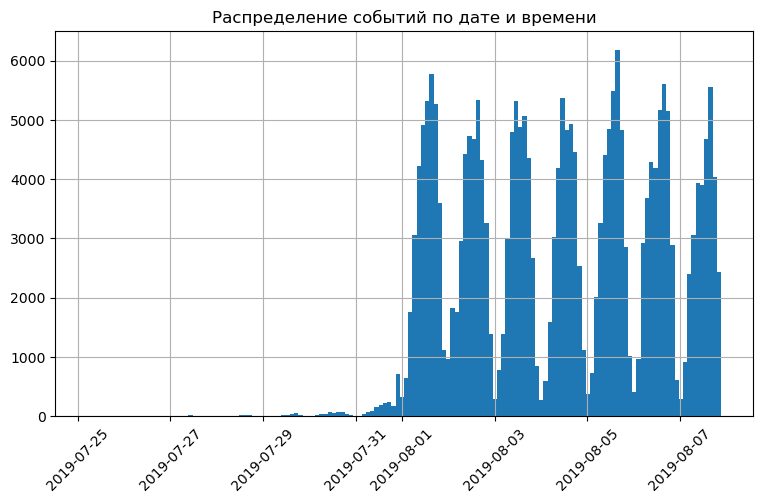

In [13]:
logs['event_datetime'].hist(bins=150, figsize=(9, 5))
plt.xticks(rotation=45)
plt.title('Распределение событий по дате и времени');

Наблюдается неравномерное распределение данных по дате и времени - данных за июль очень мало по сравнению с августом. Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого  — это может «перекашивать данные».

Примем, что с 1 августа данные полные. Таким образом, мы обладаем данными за период с 1 по 7 августа 2019 года.

Узнаем количество событий и пользователей из периода с неполными данными.

In [14]:
print('Количество событий из периода с неполными данными: {}'.format(
    logs.query('event_date < datetime(2019, 8, 1).date()').shape[0]))
print('Процент неполных данных: {0:.2f}%'.format(
    logs.query('event_date < datetime(2019, 8, 1).date()').shape[0] / 
    logs.query('event_date >= datetime(2019, 8, 1).date()').shape[0] * 100
))
print('Количество пользователей с неполными данными: {}'.format(
    logs.query('event_date < datetime(2019, 8, 1).date()')['user_id'].nunique()))
print('Процент пользователей с неполными данными: {0:.2f}%'.format(
    logs.query('event_date < datetime(2019, 8, 1).date()')['user_id'].nunique() / 
    logs.query('event_date >= datetime(2019, 8, 1).date()')['user_id'].nunique() * 100
))

Количество событий из периода с неполными данными: 2826
Процент неполных данных: 1.17%
Количество пользователей с неполными данными: 1451
Процент пользователей с неполными данными: 19.26%


In [15]:
# список пользователей с полными данными
full_data_users = logs.query('event_date >= datetime(2019, 8, 1).date()')['user_id'].unique().tolist()

# количество пользователей, входящих только в период до 1 августа
print('Количество пользователей, входящих только в период до 1 августа: {}'.format(
    logs.query('event_date < datetime(2019, 8, 1).date() and user_id not in @full_data_users')['user_id'].nunique())
       )

# количество пользователей, входящих в периоды и до 1 августа, и после
print('Количество пользователей, входящих в периоды и до 1 августа, и после: {}'.format(
    logs.query('event_date < datetime(2019, 8, 1).date() and user_id in @full_data_users')['user_id'].nunique())
       )

# процент пользователей, входящих только в период до 1 августа
print('Процент пользователей, входящих только в период до 1 августа: {0:.2f}%'.format(
    logs.query('event_date < datetime(2019, 8, 1).date() and user_id not in @full_data_users')['user_id'].nunique() /
    logs['user_id'].nunique() * 100)
       )

Количество пользователей, входящих только в период до 1 августа: 17
Количество пользователей, входящих в периоды и до 1 августа, и после: 1434
Процент пользователей, входящих только в период до 1 августа: 0.23%


При удалении событий из периода с неполными данными теряется 1.17% строк. В них содержатся данные 1451 уникального пользователя - это 19.26% всех пользователей. Но полностью теряются только 17 пользователей - 0.23% от всех пользователей, остальные 1434 пользователя из периода с неполными данными остаются в периоде с 1 по 7 августа.

Удалим 2826 строк (1.17%) с неполными старыми данными:

In [16]:
logs = logs.query('event_date >= datetime(2019, 8, 1).date()')

### Пользователи групп

Проверим, остались ли в нашем датафрейме пользователи из всех трёх групп:

In [17]:
logs.groupby('group').agg({'user_id': ['count', 'nunique']})

user_id        
        count nunique
group                
246     79302    2484
247     77022    2513
248     84563    2537

Во всех трёх группах присутствуют пользователи.

Проверим, имеются ли пользователи, состоящие одновременно в разных группах:

In [18]:
logs.groupby('user_id').agg({'group': 'nunique'}).query('group > 1')

,group
user_id,


Таких пользователей не имеется.

**Вывод:**

Провели предобработку и проверку данных:
- исключили явные дубликаты
- привели столбец даты и времени к нужному формату
- отсеяли события с неполными данными - остался период с 1-ого августа по 7-ое августа 2019 года
- провели проверку на наличие пользователей в группах.

## Воронка событий

### Частота событий

Узнаем, какие события есть в логах и как часто они встречаются.

In [19]:
logs.groupby('event_name').agg({'user_id': 'count'}).sort_values('user_id', ascending=False)

,user_id
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


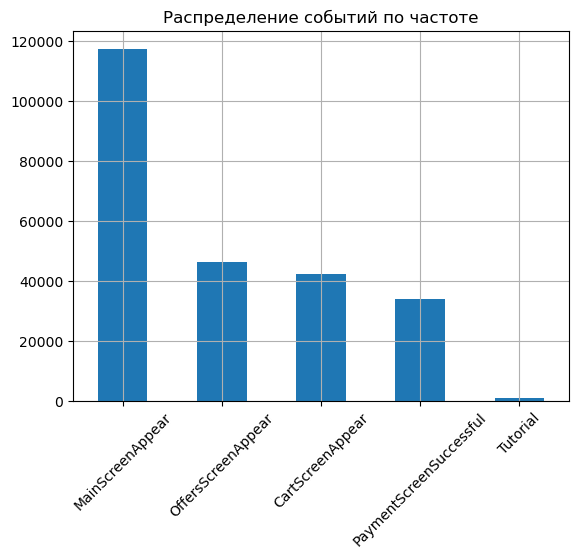

In [20]:
logs['event_name'].value_counts().plot(kind='bar', grid=True)
plt.xticks(rotation=45)
plt.title('Распределение событий по частоте');

В логах встречаются следующие события (в порядке убывания частоты):
- отображение главного экрана - встречается чаще всего
- отображение экрана каталога
- отображение корзины
- экран успешной оплаты
- руководство - встречается реже всего, небольшое количество пользователей читают руководство.

На первый взгляд экраны каталога, корзины и успешной оплаты встречаются примерно с одной частотой, нет очень больших разрывов, таких, как между главным экраном и экраном предложений.

### Количество пользователей, совершивших событие

Узнаем, сколько пользователей совершали каждое из этих событий, а также посчитаем процент пользователей от их общего количества, которые хоть раз совершали событие.

In [21]:
events_users = logs.groupby('event_name').agg({'user_id': 'nunique'}).sort_values('user_id', ascending=False)
events_users.columns = ['users_total']
events_users['perc'] = round(events_users['users_total'] / logs['user_id'].nunique() * 100, 2)
events_users

,users_total,perc
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


Можно сделать вывод, что события происходят в следующем порядке:
```
1) отображение главного экрана
2) отображение экрана каталога
3) отображение экрана корзины
4) отображение экрана успешной оплаты.
```
Отображение экрана руководства опционально - пользователь может перейти на этот экран в любое время, для совершения покупки не обязательно его просматривать, поэтому не будем учитывать его в расчёте воронки событий.

In [22]:
# расчёт воронки
logs_funnel = (
    logs
    .query('event_name != "Tutorial"')
    .groupby('event_name')
    .agg({'user_id': 'nunique'})
    .sort_values('user_id', ascending=False)
)
logs_funnel.columns = ['users_total']
logs_funnel['perc'] = round(
    logs_funnel['users_total'] / logs.query('event_name != "Tutorial"')['user_id'].nunique() * 100, 2
)
logs_funnel

,users_total,perc
event_name,,
MainScreenAppear,7419,98.53
OffersScreenAppear,4593,61.00
CartScreenAppear,3734,49.59
PaymentScreenSuccessful,3539,47.00


Можно заметить, что не все пользователи попадают на главный экран. Возможно, начало сессий этих пользователей обрезалось на этапе удаления периода с неполными данными.

### Доли пользователей, перешедших на следующий шаг воронки

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). Для расчёта нам понрадобится метод shift(), который при параметрах по умолчанию возвращает значение предыдущей строки - в нашем случае вернётся количество пользователей на предыдущем шаге воронки.

In [23]:
logs_funnel['conversion'] = round(logs_funnel['users_total'] / logs_funnel['users_total'].shift() * 100, 2)
# заполним образовавшийся пропуск в первом шаге значением 100%
logs_funnel = logs_funnel.fillna(100)
# для наглядности добавим столбец с процентом потерь пользователей при переходе от одного шага к следующему
logs_funnel['users_loss'] = 100 - logs_funnel['conversion']
logs_funnel

,users_total,perc,conversion,users_loss
event_name,,,,
MainScreenAppear,7419,98.53,100.00,0.00
OffersScreenAppear,4593,61.00,61.91,38.09
CartScreenAppear,3734,49.59,81.30,18.70
PaymentScreenSuccessful,3539,47.00,94.78,5.22


Больше всего пользователей теряется при переходе с главного экрана в каталог - 38.09%. Возможно, есть проблема с удобством перехода в каталог.

Рассчитаем процент пользователей, дошедших с главного экрана до оплаты:

In [24]:
print('Процент пользователей, дошедших от главного экрана до оплаты: {0:.2f}%'.format(
    logs_funnel['users_total'][-1] / logs_funnel['users_total'][0] * 100
)
     )

Процент пользователей, дошедших от главного экрана до оплаты: 47.70%


47.7% пользователей после главного экрана совершили покупку - это довольно высокий показатель.

## Изучение результатов эксперимента

### Количество пользователей в группах

Посчитаем количество пользователей в каждой группе:

In [25]:
group_users_total = (
    logs
    .query('event_name != "Tutorial"')
    .pivot_table(index='group', values='user_id', aggfunc='nunique')
)
group_users_total.columns = ['users_total']
# транспонируем таблицу, чтобы строки стали столбцами и наоборот
group_users_total = group_users_total.T
# объединяем две контрольные группы
group_users_total['246_247'] = group_users_total[246] + group_users_total[247]
group_users_total

group,246,247,248,246_247
users_total,2483,2512,2535,4995


На первый взгляд в экспериментальных группах примерно одинаковое количество пользователей.

Создадим сводную таблицу с количеством уникальных пользователей в каждой группе по каждому событию, а также посчитаем долю пользователей, совершивших эти события.

In [26]:
events_pivot = (
    logs
    .query('event_name != "Tutorial"')
    .pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')
    .sort_values(by=246, ascending=False)
    .reset_index()
)
events_pivot['246_247'] = events_pivot[246] + events_pivot[247]
# считаем доли пользователей, совершивших события
events_pivot['246_rate'] = round(events_pivot[246] / group_users_total.loc['users_total'][246] * 100, 2)
events_pivot['247_rate'] = round(events_pivot[247] / group_users_total.loc['users_total'][247] * 100, 2)
events_pivot['248_rate'] = round(events_pivot[248] / group_users_total.loc['users_total'][248] * 100, 2)
events_pivot['246_247_rate'] = round(events_pivot['246_247'] / group_users_total.loc['users_total']['246_247'] * 100, 2)
events_pivot

group,event_name,246,247,248,246_247,246_rate,247_rate,248_rate,246_247_rate
0,MainScreenAppear,2450,2476,2493,4926,98.67,98.57,98.34,98.62
1,OffersScreenAppear,1542,1520,1531,3062,62.10,60.51,60.39,61.30
2,CartScreenAppear,1266,1238,1230,2504,50.99,49.28,48.52,50.13
3,PaymentScreenSuccessful,1200,1158,1181,2358,48.33,46.10,46.59,47.21


Судя по сводной с небольшим опережением идёт контрольная группа 246 - доли пользователей, совершивших события в этой группе, несколько выше долей групп 247 и 248.

### Проверка контрольных групп 246 и 247

Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. 

Если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями групп 246 и 247 будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов.

Посчитаем разницу в количестве пользователей контрольных групп 246 и 247:

In [27]:
print(
    'Разница в количестве пользователей групп 246 и 247: {}%'.format(
        round((1 - logs.query('group == 246')['user_id'].nunique() /
               logs.query('group == 247')['user_id'].nunique()) * 100, 2)
    )
)

Разница в количестве пользователей групп 246 и 247: 1.15%


Разница в количестве пользователей двух контрольных групп составляет 1.15%. В идеале разница более 1% - существенное различие. За неимением лучших данных сделаем такое допущение и будем считать, что число участников контрольных групп примерно равно.

Самое популярное событие - отображение главного экрана - первый этап воронки. Проведём z-тест для контрольных групп 246 и 247 по этому событию и узнаем, есть ли статистически значимая разница между группами.

Обозначим нулевую и альтернативную гипотезы и критический уровень статистической значимости:
```
H_0: Доля пользователей группы 246, перешедших на главный экран = доля пользователей группы 247, перешедших на главный экран
H_a: Доля пользователей группы 246, перешедших на главный экран ≠ доля пользователей группы 247, перешедших на главный экран
alpha = 0.05
```

In [28]:
# критический уровень статистической значимости
alpha = 0.05
# успехи - количество пользователей групп 246 и 247, зашедшие на главный экран
successes = np.array(
    [
        events_pivot.query('event_name == "MainScreenAppear"')[246],
        events_pivot.query('event_name == "MainScreenAppear"')[247]
    ]
)
# общее количество пользователей групп 246 и 247
trials = np.array(
    [
        group_users_total[246],
        group_users_total[247]
    ]
)

# пропорция успехов в группе 246:
p1 = successes[0]/trials[0]

# пропорция успехов в группе 247:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в группах 246 и 247
difference = p1 - p2

# статистика в стандартных отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаём стандартное нормальное распределение (среднее 0, стандартное отклонение 1)
distr = st.norm(0, 1)

# рассчитываем p-value
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: {0:.5f}'.format(p_value[0]))

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p-значение: 0.75267
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Разница между долями пользователей в контрольных группах, перешедших на главный экран, статистически не значима - гипотезу о равенстве долей не отвергаем, выборки корректны.

### Проведение z-теста для всех событий контрольных групп

Напишем функцию для проведения z-теста для каждой пары групп по каждому событию.

Так как в нашем исследовании проводится множественный тест (несколько сравнений, проводимый на одних и тех же данных), нам необходимо снизить вероятность возникновения ошибки первого рода (ложнопозитивного результата). Для этого скорректируем критический уровень статистической значимости по методу Шидака и обозначим это в функции.

Для поправки нам нужно знать количество проводимых проверок. Для четырёх пар групп
```
246 - 247
246 - 248
247 - 248
246_247 - 248
```
проводится по 4 проверки для каждого события
```
главный экран
каталог
корзина
успешная покупка
```
Соответственно, в общей сложности проводится 16 проверок.

In [29]:
events_pivot

group,event_name,246,247,248,246_247,246_rate,247_rate,248_rate,246_247_rate
0,MainScreenAppear,2450,2476,2493,4926,98.67,98.57,98.34,98.62
1,OffersScreenAppear,1542,1520,1531,3062,62.10,60.51,60.39,61.30
2,CartScreenAppear,1266,1238,1230,2504,50.99,49.28,48.52,50.13
3,PaymentScreenSuccessful,1200,1158,1181,2358,48.33,46.10,46.59,47.21


In [30]:
# функция для проведения z-теста для каждой пары групп по каждому событию
def z_test(group_1, group_2, alpha):
    # делаем поправку по методу Шидака
    alpha = 1 - (1 - alpha)**(1/16)
    # запускаем цикл по индексам всех событий воронки
    for i in events_pivot.index:
        # количество пользователей групп 1 и 2 в событии i
        successes = np.array(
            [
                events_pivot[group_1][i],
                events_pivot[group_2][i]
            ]
        )
        # количество пользователей в группах 1 и 2
        trials = np.array(
            [
                group_users_total[group_1],
                group_users_total[group_2]
            ]
        )
        # пропорция успехов в группах
        p1 = successes[0]/trials[0]
        p2 = successes[1]/trials[1]
        # пропорция успехов в объединённых группах
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
        # разница пропорций успехов групп
        difference = p1 - p2
        # статистика в стандартных отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
        # задаем стандартное нормальное распределение (среднее 0, стандартное отклонение 1)
        distr = st.norm(0, 1)
        # рассчитываем p-value
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        # вывод названия события и групп
        print(events_pivot['event_name'][i], '|', group_1, '|', group_2)
        
        print('p-значение: {0:.5}'.format(p_value[0]))
        
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
            print('')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')   
            print('')

Проведём z-тест для двух контрольных групп по всем событиям воронки с учётом поправки:

```
H_0: Доля пользователей группы_1, совершивших событие = доля пользователей группы_2, совершивших событие
H_a: Доля пользователей группы_1, совершивших событие ≠ доля пользователей группы_2, совершивших событие
alpha = 0.05
```

In [31]:
z_test(246, 247, 0.05)

MainScreenAppear | 246 | 247
p-значение: 0.75267
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear | 246 | 247
p-значение: 0.24786
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear | 246 | 247
p-значение: 0.22868
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful | 246 | 247
p-значение: 0.11447
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Для всех событий нет оснований считать доли пользователей контрольных групп разными. Это означает, что разбиение на группы работает корректно.

### Проведение z-теста для всех событий группы с новым шрифтом

Проведём z-тест контрольной группы 246 и группы с новым шрифтом 248 по всем событиям воронки:

In [32]:
z_test(246, 248, 0.05)

MainScreenAppear | 246 | 248
p-значение: 0.33871
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear | 246 | 248
p-значение: 0.21442
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear | 246 | 248
p-значение: 0.080674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful | 246 | 248
p-значение: 0.21693
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Статистически значимых различий между долями нет.

Аналогично проверим группы 247 и 248:

In [33]:
z_test(247, 248, 0.05)

MainScreenAppear | 247 | 248
p-значение: 0.5195
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear | 247 | 248
p-значение: 0.93338
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear | 247 | 248
p-значение: 0.58783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful | 247 | 248
p-значение: 0.72757
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Здесь так же нет статистически значимой разницы между долями групп.

Проведём z-тест объединённой контрольной группы 246_247 и группы с новым шрифтом 248:

In [34]:
z_test('246_247', 248, 0.05)

MainScreenAppear | 246_247 | 248
p-значение: 0.34867
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear | 246_247 | 248
p-значение: 0.44583
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear | 246_247 | 248
p-значение: 0.18684
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful | 246_247 | 248
p-значение: 0.61079
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Для каждой пары групп по каждому событию нет статистически значимой разницы в долях пользователей групп, совершивших событие. Это говорит о том, что изменение шрифта никоим образом не повлияло на поведение пользователей и воронка событий не изменилась. Эксперимент можно считать удачным, и шрифт можно спокойно заменять. Но и позитивных изменений в воронке замена шрифта не произвела - все показатели остались на прежнем уровне.

### Уровень значимости

Для проведения z-тестов был выбран критический уровень статистической значимости, равный 0.05. Если бы был выбран уровень значимости 0.1, то вероятность получить ложный результат была бы равна 10% - это довольно высокий риск. Считаю выбранный мной уровень значимости 0.05 приемлемым для данного исследования.

Попробуем провести z-тест для каждой пары групп и для всех событий с заданным уровнем значимости 0.1.

In [35]:
z_test(246, 247, 0.1)
z_test(246, 248, 0.1)
z_test(247, 248, 0.1)
z_test('246_247', 248, 0.1)

MainScreenAppear | 246 | 247
p-значение: 0.75267
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear | 246 | 247
p-значение: 0.24786
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear | 246 | 247
p-значение: 0.22868
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful | 246 | 247
p-значение: 0.11447
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear | 246 | 248
p-значение: 0.33871
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear | 246 | 248
p-значение: 0.21442
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear | 246 | 248
p-значение: 0.080674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful | 246 | 248
p-значение: 0.21693
Не получилось отвергнуть нулевую гип

С более высоким уровнем значимости всё так же нет статистически значимой разницы между долями групп по всем событиям.

## Вывод

В ходе исследования была изучена воронка продаж. До покупки пользователь проходит следующие шаги:

- главный экран
- каталог продуктов
- просмотр корзины
- успешная оплата.

In [36]:
logs_funnel

,users_total,perc,conversion,users_loss
event_name,,,,
MainScreenAppear,7419,98.53,100.00,0.00
OffersScreenAppear,4593,61.00,61.91,38.09
CartScreenAppear,3734,49.59,81.30,18.70
PaymentScreenSuccessful,3539,47.00,94.78,5.22


Самым проблемным шагом воронки является переход с главного экрана в каталог - теряется 38% пользователей. Этот пункт следует изучить более подробно, возможно, пользователи сталкиваются с какой-то проблемой.

47.7% пользователей после главного экрана совершили покупку - это довольно высокий показатель.

Анализ результатов A/A/B-теста показал, что для каждой пары групп по каждому событию нет статистически значимой разницы в долях пользователей групп, совершивших событие. Это говорит о том, что изменение шрифта никоим образом не повлияло на поведение пользователей и воронка событий не изменилась. Эксперимент можно считать удачным, и шрифт можно спокойно заменять. Но и позитивных изменений в воронке замена шрифта не произвела - все показатели остались на прежнем уровне.